In [38]:
import sys
sys.path.append('../') 
from imports import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import ParameterGrid



In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [40]:
torch.cuda.is_available()

True

In [41]:
X_train = pd.read_csv('./breast-cancer-processed-data/X_train.csv').values
y_train = pd.read_csv('./breast-cancer-processed-data/y_train.csv').values
X_val = pd.read_csv('./breast-cancer-processed-data/X_val.csv').values
y_val = pd.read_csv('./breast-cancer-processed-data/y_val.csv').values
X_test = pd.read_csv('./breast-cancer-processed-data/X_test.csv').values
y_test = pd.read_csv('./breast-cancer-processed-data/y_test.csv').values

In [42]:
# Convert Numpy arrays to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create dataloaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

In [43]:
class FNN(nn.Module):
    def __init__(self, input_size):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [44]:
model = FNN(X_train.shape[1]).to(device)
criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
def calculate_accuracy(y_pred, y_true):
    # Convert predictions to binary values (0 or 1)
    predicted = torch.round(y_pred).view(-1)
    return (predicted == y_true).sum().float() / len(y_true)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
# Training and validation for certain epochs
epochs = 100
for epoch in range(epochs):  # number of epochs
    model.train()
    total_loss, total_acc = 0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += calculate_accuracy(output, target)
        
    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = total_acc / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    
    # Validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            val_acc += calculate_accuracy(output, target)
            
    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}')



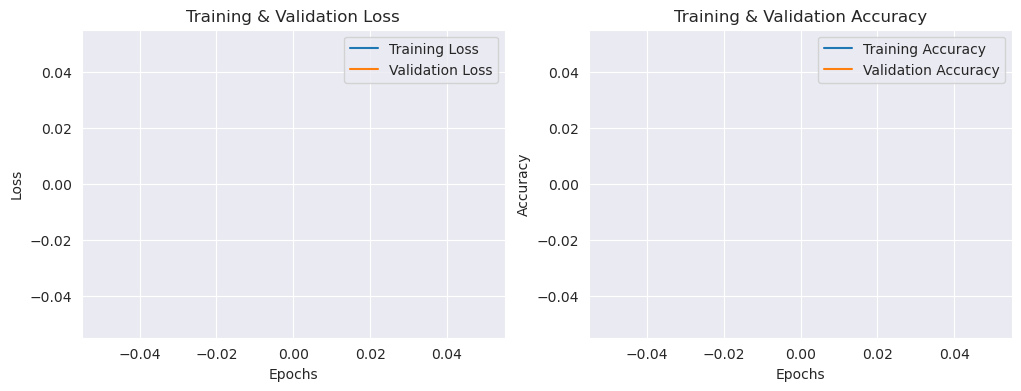

In [35]:
import matplotlib.pyplot as plt

# Plotting training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
train_accuracies = [acc.cpu().numpy() for acc in train_accuracies]
val_accuracies = [acc.cpu().numpy() for acc in val_accuracies]

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [13]:
# Testing the model
model.eval()
test_loss = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
print(f'Test Loss: {test_loss / len(test_loader)}')

Test Loss: 0.05450681410729885


In [26]:
# Now let us perform hyperparamter tuning to find optimal parameters and replace them where needed!
# Defining the parametr grid for hyperparameter tuning
param_grid = {
    'lr': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

In [27]:
# Function to train and evaluate the model
def train_val_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=3):
    
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    return val_accuracy

In [28]:
# Let us begin Hyperparameter tuning
best_accuracy = 0
best_params = None

for params in ParameterGrid(param_grid):
    # Update batch size for data loaders
    train_loader = DataLoader(TensorDataset(train_data, train_targets), batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(TensorDataset(val_data, val_targets), batch_size=params['batch_size'], shuffle=False)
    model = SingleLayerCNN().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])

    # Training and evaluating the model
    accuracy = train_val_evaluate(model, train_loader, val_loader, criterion, optimizer, params['epochs'])
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

    print(f"Params: {params}, Validation Accuracy: {accuracy:.2f}%")

print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy:.2f}%")

Params: {'batch_size': 32, 'epochs': 50, 'lr': 0.001}, Validation Accuracy: 89.57%
Params: {'batch_size': 32, 'epochs': 50, 'lr': 0.01}, Validation Accuracy: 85.95%
Params: {'batch_size': 32, 'epochs': 100, 'lr': 0.001}, Validation Accuracy: 89.33%
Params: {'batch_size': 32, 'epochs': 100, 'lr': 0.01}, Validation Accuracy: 85.05%
Params: {'batch_size': 64, 'epochs': 50, 'lr': 0.001}, Validation Accuracy: 89.43%
Params: {'batch_size': 64, 'epochs': 50, 'lr': 0.01}, Validation Accuracy: 86.43%
Params: {'batch_size': 64, 'epochs': 100, 'lr': 0.001}, Validation Accuracy: 89.75%
Params: {'batch_size': 64, 'epochs': 100, 'lr': 0.01}, Validation Accuracy: 86.27%
Best Params: {'batch_size': 64, 'epochs': 100, 'lr': 0.001}, Best Accuracy: 89.75%


In [33]:

model = SingleLayerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [36]:
import matplotlib.pyplot as plt

train_accuracies = []
val_accuracies = []
# Data loaders and set batch size for training, validation, testing
batch_size = 64
train_loader = DataLoader(TensorDataset(train_data, train_targets), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_data, val_targets), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_data, test_targets), batch_size=batch_size, shuffle=False)
# Training and validation for certain epochs
epochs = 100
for epoch in range(epochs):
    model.train()
    total_train = 0
    correct_train = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], Training accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')



Epoch [1/100], Training accuracy: 93.53%, Validation Accuracy: 90.28%
Epoch [2/100], Training accuracy: 94.20%, Validation Accuracy: 90.03%
Epoch [3/100], Training accuracy: 94.68%, Validation Accuracy: 90.53%
Epoch [4/100], Training accuracy: 95.13%, Validation Accuracy: 90.32%
Epoch [5/100], Training accuracy: 95.55%, Validation Accuracy: 90.68%
Epoch [6/100], Training accuracy: 95.84%, Validation Accuracy: 90.87%
Epoch [7/100], Training accuracy: 96.30%, Validation Accuracy: 90.37%
Epoch [8/100], Training accuracy: 96.43%, Validation Accuracy: 90.28%
Epoch [9/100], Training accuracy: 96.80%, Validation Accuracy: 90.27%
Epoch [10/100], Training accuracy: 97.04%, Validation Accuracy: 90.08%
Epoch [11/100], Training accuracy: 97.27%, Validation Accuracy: 90.55%
Epoch [12/100], Training accuracy: 97.41%, Validation Accuracy: 90.28%
Epoch [13/100], Training accuracy: 97.69%, Validation Accuracy: 90.25%
Epoch [14/100], Training accuracy: 97.73%, Validation Accuracy: 90.15%
Epoch [15/100],

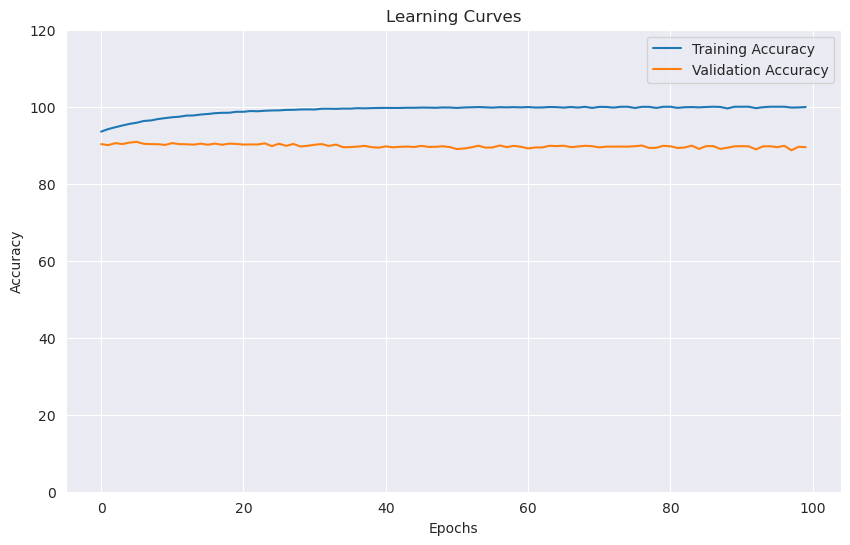

In [38]:

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0,120])
plt.legend()
plt.grid(True)
plt.show()